In [3]:
import numpy as np
import gym
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

In [4]:
# Create gym environment
env = gym.make('Pendulum-v0')
env.reset()
#action space is a Box(1,) with values between [-2,2], joint effort
print(env.action_space.low)
#observation space is 3d angle of pendulum cos, sin, velocity max:1,1,8; min:-1,-1,8
print(env.observation_space.low)

[-2.]
[-1. -1. -8.]


In [5]:
#reward formular: -(theta^2 + 0.1*theta_dt^2 + 0.001*action^2) (-16.27 is worst, 0 best)
print(env.reset())
a = env.action_space.sample()
print(a)
state, reward, done, info = env.step(a)
print(state, reward, done, info)

[ 0.07509069 -0.99717671  0.3350061 ]
[0.19525401]
[ 0.05595279 -0.99843342 -0.38358833] -2.2481847490087477 False {}


In [6]:
# Learning episodes
epochs = 10000

Regression...
...done
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


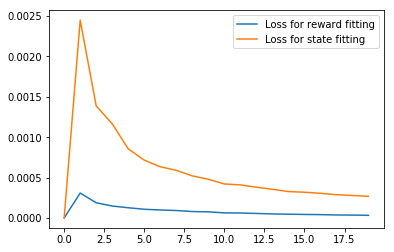

In [53]:
"""
    Regression of old state and performed action to new state and observed reward.
"""

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


rtx = []
rty = []
stx = []
sty = []
plotr = []
plots = []

regressorReward = RandomForestRegressor(n_estimators=10, min_samples_split=2)
regressorState = RandomForestRegressor(n_estimators=10, min_samples_split=2)

print("Regression...")
for i in range(epochs):
    observation = env.reset() # do we really need to call this every episode?

    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    rtx.append(np.append(observation,action))
    rty.append(reward)
    stx.append(np.append(observation,action))
    sty.append(state)
    #observation = state
    if i%500==0:
        
        regressorReward.fit(rtx, rty)
        fitrtx = regressorReward.predict(rtx)
        mse = mean_squared_error(rty, fitrtx)
        plotr.append(mse)

        
        regressorState.fit(stx, sty)
        fitstx = regressorState.predict(stx)
        mse = mean_squared_error(sty, fitstx)

        plots.append(mse)

print("...done")
plt.figure(0)
plt.plot(plotr, label="Loss for reward fitting")

plt.plot(plots, label="Loss for state fitting")
plt.legend()
print(regressorReward)

In [32]:
"""
    Discretization
    
    We translate the state from [-1, 1] [-1, 1] [-8, 8]
    to [0, 2] [0, 2] [0, 16]
    
    We translate the actions from [-2, 2] to [0, 4]
    
    Then we round the input with variable number of decimal places
    and multiply by 10 to the power of this number
    to make sure we get only positive integers
    
"""

def discretization(state_action, x, decimal_number):
    if state_action=="state":
        positive_s = [x[0]+1, x[1]+1, x[2]+8]
        rounded_s = np.around(positive_s, decimals=decimal_number)
        int_s = rounded_s * (10**decimal_number)
        int_s = np.array([int(int_s[0]), int(int_s[1]), int(int_s[2])])
        return int_s
    if state_action=="action":
        positive_a = x + 2
        rounded_a = np.around(positive_a, decimals=decimal_number)
        int_a = int(rounded_a * (10**decimal_number))
        return int_a
    else:
        print("Unknown discretization")
        return -1

In [33]:
"""
   Value Iteration
   
"""

'\n   Value Iteration\n   \n'

In [51]:
"""
    Policy Iteration
    
    Gives convergence towards the optimal policy by iteratively
    performing Policy Evaluation and Policy Improvement

"""
state = env.reset()

for _ in range(10):
    #env.render()
    print("Old state: ", discretization("state", state, 1))
    action = env.action_space.sample()
    print("Action: ", discretization("action", action, 1))
    state, reward, done, info = env.step(action)
    x = np.append(state,action)
    x = x.reshape(-1,1)
    print("Predicted reward: ", regressorReward.predict(x))
    print()

env.close()

Old state:  [17  3 85]
Action:  28


ValueError: Number of features of the model must match the input. Model n_features is 4 and input n_features is 1 